In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 10)

## Phenomenon Being Modeled 

This analysis models the sequential patterning of infrastructure damage in Ukraine since the full-scale Russian invasion on 24 February 2022. The phenomenon is not just the volume of attacks, but their order and progression over time, specifically, whether an attack in one location or on one type of infrastructure increases the probability of the next attack occurring in another specific location or on another specific type.

## Background

The analysis is built upon data from the Armed Conflict Location & Event Data (ACLED) project. ACLED is a non-profit organization that gathers, analyzes, and maps real-time data on political violence and protest events worldwide.

Data: The ukraine-damages.csv file used in this project is a curated data file from ACLED's Ukraine Conflict Monitor.

Event: ACLED's fundamental unit of analysis. It is a single, discrete incident of political violence, coded by its date, location, actors involved, and event type (e.g., "Battles," "Explosions/remote violence," "Violence against civilians"). The provided dataset is a time-ordered sequence of these events, specifically those resulting in infrastructure damage.

State: In the Markov Chain model, a "state" is the specific category of a given damage event. The notebook explores two types of states:

Geographic State: The region (Oblast) where the damage occurred.

Infrastructure State: The type of infrastructure that was damaged.

Transition: This represents the progression from one damage event to the next sequential event in the time-ordered dataset. The model calculates a transition probability matrix containing the likelihood of moving from any given state to any other state (e.g., from an attack in "Kyivska" to one in "Lvivska," or from "Business" infrastructure to "Civilian" infrastructure).

## Main Features 

The analysis in the notebook reveals several key features of this phenomenon:

Geographic States (Oblast): The analysis is performed at the Oblast (region) level. The rayon (district) level was considered but deemed unsuitable for this model due to a high volume of missing data (35.9% of 24,269 entries). The oblast level, by contrast, had only 0.03% missing data, providing a robust foundation for the model.

Infrastructure States (Categories): A second Markov model was built to analyze the type of target. The original 26 unique infrastructure types were consolidated into 8 broader, more practical categories: Business, Civillian, Power & Fuel, Government facilities, Resources, Transportation, Other, and Unknown.

High Self-Transition Probability: A primary finding, visible in the heatmaps, is the high probability of "self-transition." This means the most likely location or target-type for the next damage event is the same as the current one. This suggests that attacks often occur in clusters or concentrated waves.

Data Support: The transition matrix for Oblast shows a 0.75 probability that a strike in Donetska will be followed by another strike in Donetska.

Data Support: Similarly, the recoded infrastructure matrix shows a 0.61 probability that an attack on a "Civillian" target will be followed by another attack on a "Civillian" target.

Steady-State Distribution (Long-Term Projections): By repeatedly applying the transition matrix, the model projects the long-term probabilities of attacks. The projections show that the model reaches a stationary distribution (or "steady state") quickly, stabilizing by approximately 50 "strikes" (events). This distribution represents the long-term forecast for where any given damage event is likely to occur, regardless of where the attacks began.

Data Support: The long-term projection (After 2000 strikes) starting from "Luhanska" shows the highest probabilities of an event occurring in:

Donetska: ~25.1%

Dnipropetrovska: ~16.7%

Kharkivska: ~14.0%

In [3]:
#import the data
data = pd.read_csv("ukraine-damages.csv", delimiter = "|")
data.head(20)

,damage_id,iso3,country,gid_1,oblast,rayon,type_of_infrastructure,if_other_what,date_of_event,source_name,source_date,source_link,additional_sources,extent_of_damage,_internal_filter_date,_weights,access_subindicator,pcode
0,D0011,UKR,Ukraine,['UKR.15_1'],Luhanska,Siverskodonetskyi,Warehouse,NaN,2022-03-25,OCHA,2022-03-28,https://reliefweb.int/report/ukraine/ukraine-h...,NaN,Destroyed,2022-03-25,0.7,['7.2'],UA44
1,D0012,UKR,Ukraine,['UKR.15_1'],Luhanska,Siverskodonetskyi,Warehouse,NaN,2022-03-26,OCHA,2022-03-28,https://reliefweb.int/report/ukraine/ukraine-h...,NaN,Partially damaged,2022-03-26,0.7,['7.2'],UA44
2,D0015,UKR,Ukraine,['UKR.14_1'],Lvivska,NaN,Warehouse,NaN,2022-03-26,OCHA,2022-03-28,https://reliefweb.int/report/ukraine/ukraine-h...,NaN,Unknown,2022-03-26,1.0,['7.2'],UA46
3,D0016,UKR,Ukraine,['UKR.14_1'],Lvivska,NaN,Aircraft repair plant,Aircraft repair plan,2022-03-26,OCHA,2022-03-28,https://reliefweb.int/report/ukraine/ukraine-h...,NaN,Destroyed,2022-03-26,1.0,['7.2'],UA46
4,D0017,UKR,Ukraine,['UKR.12_1'],Kyivska,NaN,Bridge,NaN,2022-03-22,OCHA,2022-03-28,https://reliefweb.int/report/ukraine/ukraine-h...,NaN,Destroyed,2022-03-22,1.0,['9.2'],UA32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,D0034,UKR,Ukraine,['UKR.6_1'],Donetska,Donetskyi,"Education facility (school, etc.)",NaN,2022-02-25,Save the Children,2022-02-27,https://reliefweb.int/sites/reliefweb.int/file...,https://www.savethechildren.net/news/ukraine-a...,Partially damaged,2022-02-25,0.7,['7.2'],UA14
16,D0035,UKR,Ukraine,['UKR.21_1'],Sumska,Okhtyrskyi,"Education facility (school, etc.)",NaN,2022-02-25,Amnesty International,2022-02-27,https://www.amnestyusa.org/press-releases/clus...,https://reliefweb.int/sites/reliefweb.int/file...,Partially damaged,2022-02-25,0.7,['7.2'],UA59
17,D0038,UKR,Ukraine,['UKR.12_1'],Kyivska,Bilotserkivskyi,Oil depot,Oil Depot,2022-03-26,OCHA,2022-02-27,https://reliefweb.int/sites/reliefweb.int/file...,NaN,Unknown,2022-03-26,0.7,['7.2'],UA32
18,D0039,UKR,Ukraine,['UKR.8_1'],Kharkivska,Kharkivskyi,Gas supply system,NaN,2022-02-26,OCHA,2022-02-27,https://reliefweb.int/sites/reliefweb.int/file...,NaN,Unknown,2022-02-26,0.7,['7.2'],UA63


In [4]:
"""
    'damage_id',                >> primary key, identifies a given instance of damage upon infrastructure
    
    'iso3',                     >> Three-digit International Standards Organization (ISO) country code.  Only one value, "UKR", in all 
                                        24269 rows--all data is for Ukraine/UKR  Categorical string.
    
    'country',                  >> Same situation as 'iso3', "Ukraine" in all 24269 rows.  Country in which the infrastructure was damaged.
    
    'gid_1',                    >> Not sure what "gid" is, but the value counts for this and "oblast" appear to correlate.  One could 
                                        infer it loosely breaks out to "geographic identifier. "Based on this, we assess it to 
                                        be a categorical string.
    
    'oblast',                   >> An "oblast" is the primary administrative division of Ukraine, loosely translated to "region"/"province".
                                        The individual values correlate to the (24 oblasts + 2 cities with special status + 1 autonomous 
                                        republic) identified/recognized as comprising Ukraine.  Categorical string.
    
    'rayon',                    >> A "rayon" is the secondary administrative division of Ukraine, i.e., an oblast is subdivided into 
                                        rayons. Essentially "districts."  Categorical string.
    
    'type_of_infrastructure',   >> Categorical description of the infrastructure damaged in the incident  Categorical string.
    
    'if_other_what',            >> Optional, supplementary field to describe the infrastructure damaged in the incident
                                        if the categories of 'type_of_infrastructure' are insufficient.  Free-entry string.
    
    'date_of_event',            >> Date upon which the attack happened/the infrastructure was damaged.  Date.
    
    'source_name',              >> Name of the (primary) source from which the observation was collected.  Free-entry string.
    
    'source_date',              >> Date upon which the source reported its collection.  Date.
    
    'source_link',              >> hyperlink at which one can find the reporting.  Free-entry string.
    
    'additional_sources',       >> (optional) name(s) of sources providing corroborating and/or supplementary information on the event.
                                        Free-entry string.

    'extent_of_damage',         >> categorical, qualitative assessment of the damage done.  Categorical string.
    
    '_internal_filter_date',    >> internal variable used by the collector, not necessary for our purposes
    
    '_weights',                 >> internal variable used by the collector, not necessary for our purposes
    
    'access_subindicator',      >> internal variable used by the collector, not necessary for our purposes
    
    'pcode'                     >> internal variable used by the collector, not necessary for our purposes
"""

'\n    \'damage_id\',                >> primary key, identifies a given instance of damage upon infrastructure\n\n    \'iso3\',                     >> Three-digit International Standards Organization (ISO) country code.  Only one value, "UKR", in all \n                                        24269 rows--all data is for Ukraine/UKR  Categorical string.\n\n    \'country\',                  >> Same situation as \'iso3\', "Ukraine" in all 24269 rows.  Country in which the infrastructure was damaged.\n\n    \'gid_1\',                    >> Not sure what "gid" is, but the value counts for this and "oblast" appear to correlate.  One could \n                                        infer it loosely breaks out to "geographic identifier. "Based on this, we assess it to \n                                        be a categorical string.\n\n    \'oblast\',                   >> An "oblast" is the primary administrative division of Ukraine, loosely translated to "region"/"province".\n                 

In [4]:
#Oblast is the region
#Rayon is the district within the region
#I think it makes the most sense to model at the Rayon level as these are smaller than Oblasts
#how many rayon are NaN?
a = data['rayon'].isna().sum()
b = data['rayon'].value_counts()
a,b


(np.int64(8720),
 rayon
 Nikopolskyi     2474
 Kramatorskyi    2274
 Kharkivskyi     1308
 Khersonskyi     1187
 Pokrovskyi       733
                 ... 
 Khmilnytskyi       1
 Yaltynskyi         1
 Zhmerynskyi        1
 Sambirskyi         1
 Kovelskyi          1
 Name: count, Length: 113, dtype: int64)

In [6]:
missing_r = (8720/24269)*100
missing_r

35.93061106761712

Having 35% of the rayons missing kinda stinks...

Let evaluate the oblasts for missingness

In [7]:
#how many oblasts are NaN?
c = data['oblast'].isna().sum()
d = data['oblast'].value_counts()
c,d

(np.int64(8),
 oblast
 Donetska                         6095
 Dnipropetrovska                  4053
 Kharkivska                       3393
 Khersonska                       2305
 Mykolaivska                      2110
                                  ... 
 Volynska                           16
 Autonomous Republic of Crimea      16
 Zakarpatska                        12
 Chernivetska                        7
 Sevastopol                          5
 Name: count, Length: 27, dtype: int64)

In [8]:
missing_o = (8/24269)*100
missing_o

0.03296386336478636

Having only .03% missing is much more tolerable

I'll continue the code using the Oblasts vs the Rayons but this can be revised later, maybe we can fill NaN vlaues with the corresponding Oblast for missing 
Rayons?

Group met on 11/11 proposed to change NaN values to 'Unknown'

In [5]:
#Convert missing values to 'Unknown'
data['rayon'] = data['rayon'].fillna('Missing')
data['oblast'] = data['oblast'].fillna('Unknown')
data.head(20)

,damage_id,iso3,country,gid_1,oblast,rayon,type_of_infrastructure,if_other_what,date_of_event,source_name,source_date,source_link,additional_sources,extent_of_damage,_internal_filter_date,_weights,access_subindicator,pcode
0,D0011,UKR,Ukraine,['UKR.15_1'],Luhanska,Siverskodonetskyi,Warehouse,NaN,2022-03-25,OCHA,2022-03-28,https://reliefweb.int/report/ukraine/ukraine-h...,NaN,Destroyed,2022-03-25,0.7,['7.2'],UA44
1,D0012,UKR,Ukraine,['UKR.15_1'],Luhanska,Siverskodonetskyi,Warehouse,NaN,2022-03-26,OCHA,2022-03-28,https://reliefweb.int/report/ukraine/ukraine-h...,NaN,Partially damaged,2022-03-26,0.7,['7.2'],UA44
2,D0015,UKR,Ukraine,['UKR.14_1'],Lvivska,Missing,Warehouse,NaN,2022-03-26,OCHA,2022-03-28,https://reliefweb.int/report/ukraine/ukraine-h...,NaN,Unknown,2022-03-26,1.0,['7.2'],UA46
3,D0016,UKR,Ukraine,['UKR.14_1'],Lvivska,Missing,Aircraft repair plant,Aircraft repair plan,2022-03-26,OCHA,2022-03-28,https://reliefweb.int/report/ukraine/ukraine-h...,NaN,Destroyed,2022-03-26,1.0,['7.2'],UA46
4,D0017,UKR,Ukraine,['UKR.12_1'],Kyivska,Missing,Bridge,NaN,2022-03-22,OCHA,2022-03-28,https://reliefweb.int/report/ukraine/ukraine-h...,NaN,Destroyed,2022-03-22,1.0,['9.2'],UA32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,D0034,UKR,Ukraine,['UKR.6_1'],Donetska,Donetskyi,"Education facility (school, etc.)",NaN,2022-02-25,Save the Children,2022-02-27,https://reliefweb.int/sites/reliefweb.int/file...,https://www.savethechildren.net/news/ukraine-a...,Partially damaged,2022-02-25,0.7,['7.2'],UA14
16,D0035,UKR,Ukraine,['UKR.21_1'],Sumska,Okhtyrskyi,"Education facility (school, etc.)",NaN,2022-02-25,Amnesty International,2022-02-27,https://www.amnestyusa.org/press-releases/clus...,https://reliefweb.int/sites/reliefweb.int/file...,Partially damaged,2022-02-25,0.7,['7.2'],UA59
17,D0038,UKR,Ukraine,['UKR.12_1'],Kyivska,Bilotserkivskyi,Oil depot,Oil Depot,2022-03-26,OCHA,2022-02-27,https://reliefweb.int/sites/reliefweb.int/file...,NaN,Unknown,2022-03-26,0.7,['7.2'],UA32
18,D0039,UKR,Ukraine,['UKR.8_1'],Kharkivska,Kharkivskyi,Gas supply system,NaN,2022-02-26,OCHA,2022-02-27,https://reliefweb.int/sites/reliefweb.int/file...,NaN,Unknown,2022-02-26,0.7,['7.2'],UA63


In [6]:
oblasts = data[['oblast']].copy()
oblasts.reset_index(drop=True, inplace=True)
oblasts.head(20)

,oblast
0,Luhanska
1,Luhanska
2,Lvivska
3,Lvivska
4,Kyivska
...,...
15,Donetska
16,Sumska
17,Kyivska
18,Kharkivska


## Oblast Markov Projections

### Create Transition Matrix for Oblast Analysis

In [9]:
# TRANSITION MATRIX - OBLAST

states_o = list(oblasts["oblast"].unique())
#states_i2

# step 2: compute transition counts/matrix >> adapting code from bach.py
# REMEMBER, it's a normalized matrix

S_o = len(states_o)
#T = len(bach)
tr_counts_o = np.zeros( (S_o, S_o) )

## Compute transition counts:
for row in range(1,len(oblasts["oblast"])): # check two lines down for why we start at 1

    # Current and next tokens:
    x_tm1 = oblasts["oblast"][row-1] # previous state >> this is why we start at 1! bc we are collecting previous state.
    x_t = oblasts["oblast"][row] # current state
    # Determine transition indices:
    index_from = states_o.index(x_tm1)
    index_to = states_o.index(x_t)
    # Update transition counts:
    tr_counts_o[index_from, index_to] += 1

#print('Transition Counts:\n', tr_counts_o)

# Sum the transition counts by row >> numpy axis 0 is technically rows, but visually it's columns. "rows" is what we want
sums_o = tr_counts_o.sum(axis=1, keepdims=True)
#print('State proportions: \n')

# Normalize the transition count matrix to get proportions:
tr_pr_o = np.divide(tr_counts_o, sums_o, 
                             out=np.zeros_like(tr_counts_o), 
                             where=sums_o!=0)

#print('Transition Proportions:\n')

oblast_tr_df = pd.DataFrame(np.round(tr_pr_o,2), index=states_o, columns=states_o)
#oblast_tr_df

# output truncated for brevity

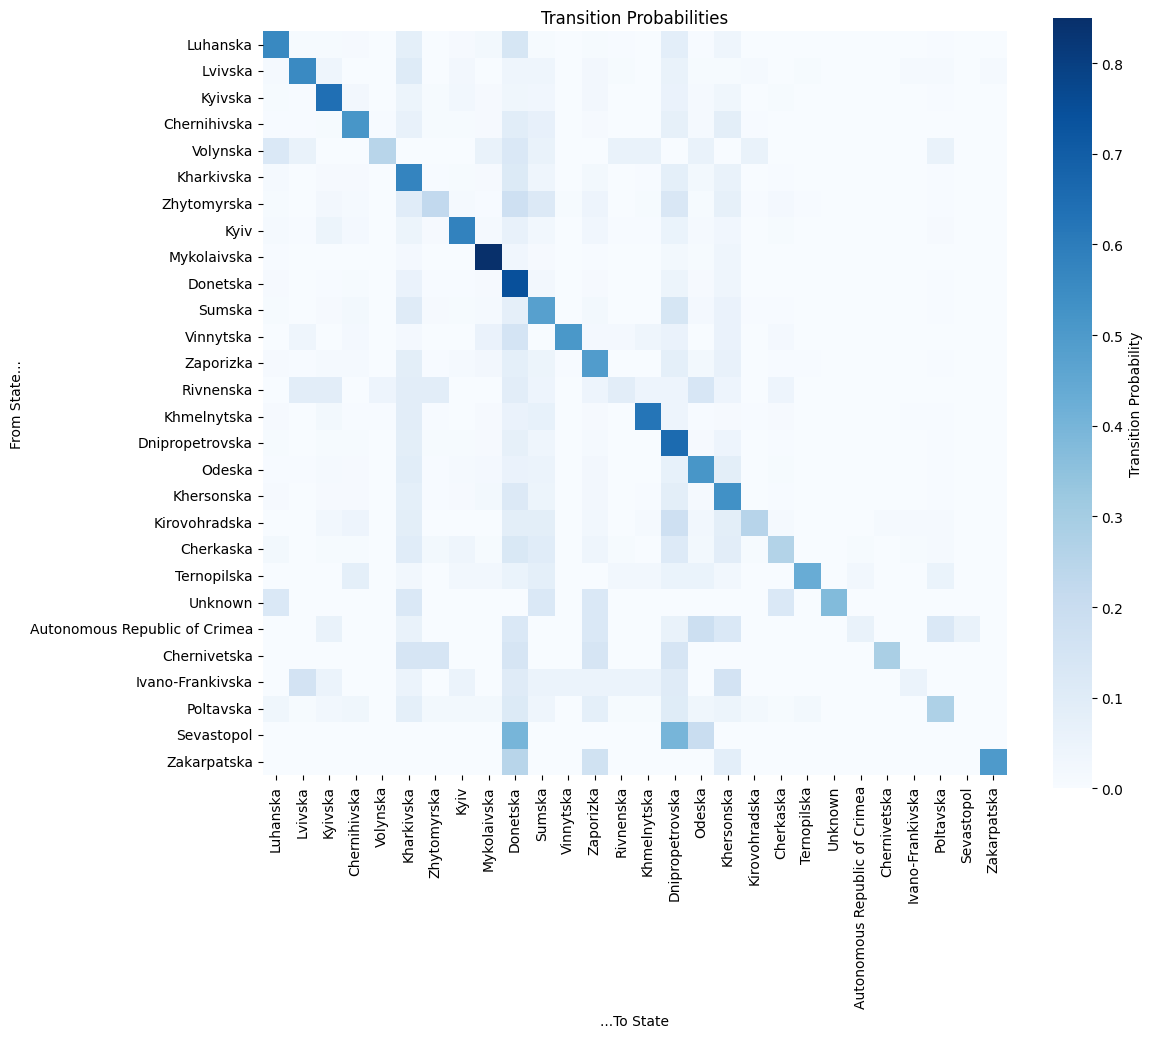

In [10]:
plt.figure(figsize=(12, 10))
sns.heatmap(tr_pr_o,                  # proportions
            cmap='Blues',    
            square=True,          
            xticklabels=states_o,     
            yticklabels=states_o,     
            cbar_kws={'label': 'Transition Probability'})

plt.title('Transition Probabilities')
plt.xlabel('...To State')
plt.ylabel('From State...')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Markov Projections for Oblast Analysis

In [13]:
# oblast projections

# transition matrix: oblast_tr_df
# oblast[0] = Luhanska

# find the index of the starting point

length_o = len(oblast_tr_df.columns)

for i in range(length_o):
    if oblast_tr_df.columns[i] == "Luhanska":
        starting_point_o = i
# initiate the projection matrix and set starting point
init_o = np.zeros(length_o) 
init_o[starting_point_o] = 1
#print(init)

time_windows = [5, 10, 25, 50, 100, 250, 500, 750, 1000, 2000]

init5_o = init_o.copy()
for i in range(5):
   #init5_o = oblast_tr_df @ init5_o
   #init5_o = init5_o @ oblast_tr_df 
   init5_o = init5_o @ tr_pr_o
#print(init2)

init10_o = init_o.copy()
for i in range(10):
   #init10_o = oblast_tr_df@init10_o
   #init10_o = init10_o@oblast_tr_df 
   init10_o = init10_o@tr_pr_o


init25_o = init_o.copy()
for i in range(25):
   #init25_o = oblast_tr_df@init25_o 
   #init25_o = init25_o@oblast_tr_df
   init25_o = init25_o@tr_pr_o  

init50_o = init_o.copy()
for i in range(50):
   #init50_o = oblast_tr_df@init50_o 
   #init50_o = init50_o@oblast_tr_df
   init50_o = init50_o@tr_pr_o

init100_o = init_o.copy()
for i in range(100):
   #init100_o = oblast_tr_df@init100_o 
   #init100_o = init100_o@oblast_tr_df
   init100_o = init100_o@tr_pr_o

init250_o = init_o.copy()
for i in range(250):
   #init250_o = oblast_tr_df@init250_o 
   #init250_o = init250_o@oblast_tr_df
   init250_o = init250_o@tr_pr_o

init500_o = init_o.copy()
for i in range(500):
   #init500_o = oblast_tr_df@init500_o 
   #init500_o = init500_o@oblast_tr_df
   init500_o = init500_o@tr_pr_o

init750_o = init_o.copy()
for i in range(750):
   #init750_o = oblast_tr_df@init750_o 
   #init750_o = init750_o@oblast_tr_df
   init750_o = init750_o@tr_pr_o

init1000_o = init_o.copy()
for i in range(1000):
   #init1000_o = oblast_tr_df@init1000_o 
   #init1000_o = init1000_o@oblast_tr_df
   init1000_o = init1000_o@tr_pr_o

init2000_o = init_o.copy()
for i in range(2000):
   #init2000_o = oblast_tr_df@init2000_o 
   #init2000_o = init2000_o@oblast_tr_df
   init2000_o = init2000_o@tr_pr_o

projections_o = pd.DataFrame({"Initial": init_o,
                            "After 5 strikes": init5_o,
                            "After 10 strikes": init10_o,
                            "After 25 strikes": init25_o,
                            "After 50 strikes": init50_o,
                            "After 100 strikes": init100_o,
                            "After 250 strikes": init250_o,
                            "After 500 strikes": init500_o,
                            "After 750 strikes": init750_o,
                            "After 1000 strikes": init1000_o,
                            "After 2000 strikes": init2000_o})
projections_o

,Initial,After 5 strikes,After 10 strikes,After 25 strikes,After 50 strikes,After 100 strikes,After 250 strikes,After 500 strikes,After 750 strikes,After 1000 strikes,After 2000 strikes
0,1.0,0.073269,0.026828,0.024154,0.024139,0.024139,0.024139,0.024139,0.024139,0.024139,0.024139
1,0.0,0.007295,0.005538,0.005278,0.005273,0.005273,0.005273,0.005273,0.005273,0.005273,0.005273
2,0.0,0.022592,0.026316,0.026602,0.026578,0.026578,0.026578,0.026578,0.026578,0.026578,0.026578
3,0.0,0.020923,0.021391,0.021279,0.021262,0.021262,0.021262,0.021262,0.021262,0.021262,0.021262
4,0.0,0.000625,0.000666,0.000660,0.000659,0.000659,0.000659,0.000659,0.000659,0.000659,0.000659
...,...,...,...,...,...,...,...,...,...,...,...
23,0.0,0.000260,0.000291,0.000289,0.000288,0.000288,0.000288,0.000288,0.000288,0.000288,0.000288
24,0.0,0.000778,0.000795,0.000784,0.000783,0.000783,0.000783,0.000783,0.000783,0.000783,0.000783
25,0.0,0.006311,0.006173,0.006104,0.006098,0.006098,0.006098,0.006098,0.006098,0.006098,0.006098
26,0.0,0.000185,0.000207,0.000206,0.000206,0.000206,0.000206,0.000206,0.000206,0.000206,0.000206


### Takes relatively few strikes before leveling out.  It is also worth noting where strikes are INFREQUENT as well, possible recommendations for field hospitals, refugee facilities, etc.

## Rayon Markov Projections

In [11]:
rayon = data[['rayon']].copy()
rayon.reset_index(drop=True, inplace=True)
rayon.head(20)

,rayon
0,Siverskodonetskyi
1,Siverskodonetskyi
2,Missing
3,Missing
4,Missing
...,...
15,Donetskyi
16,Okhtyrskyi
17,Bilotserkivskyi
18,Kharkivskyi


### Create Transition Matrix for Rayon Analysis

In [13]:
# TRANSITION MATRIX - RAYON

states_r = list(rayon["rayon"].unique())
#states_i2

# step 2: compute transition counts/matrix >> adapting code from bach.py
# REMEMBER, it's a normalized matrix

S_r = len(states_r)
#T = len(bach)
tr_counts_r = np.zeros( (S_r, S_r) )



## Compute transition counts:
for row in range(1,len(rayon["rayon"])): # check two lines down for why we start at 1

    # Current and next tokens:
    x_tm1 = rayon["rayon"][row-1] # previous state >> this is why we start at 1! bc we are collecting previous state.
    x_t = rayon["rayon"][row] # current state
    # Determine transition indices:
    index_from = states_r.index(x_tm1)
    index_to = states_r.index(x_t)
    # Update transition counts:
    tr_counts_r[index_from, index_to] += 1

#print('Transition Counts:\n', tr_counts_r)

# Sum the transition counts by row >> numpy axis 0 is technically rows, but visually it's columns. "rows" is what we want
sums_r = tr_counts_r.sum(axis=1, keepdims=True)
#print('State proportions: \n')

# Normalize the transition count matrix to get proportions:
tr_pr_r = np.divide(tr_counts_r, sums_r, 
                             out=np.zeros_like(tr_counts_r), 
                             where=sums_r!=0)

#print('Transition Proportions:\n')

rayon_tr_df = pd.DataFrame(np.round(tr_pr_r,2), index=states_r, columns=states_r)
#rayon_tr_df.head()

# output truncated for brevity

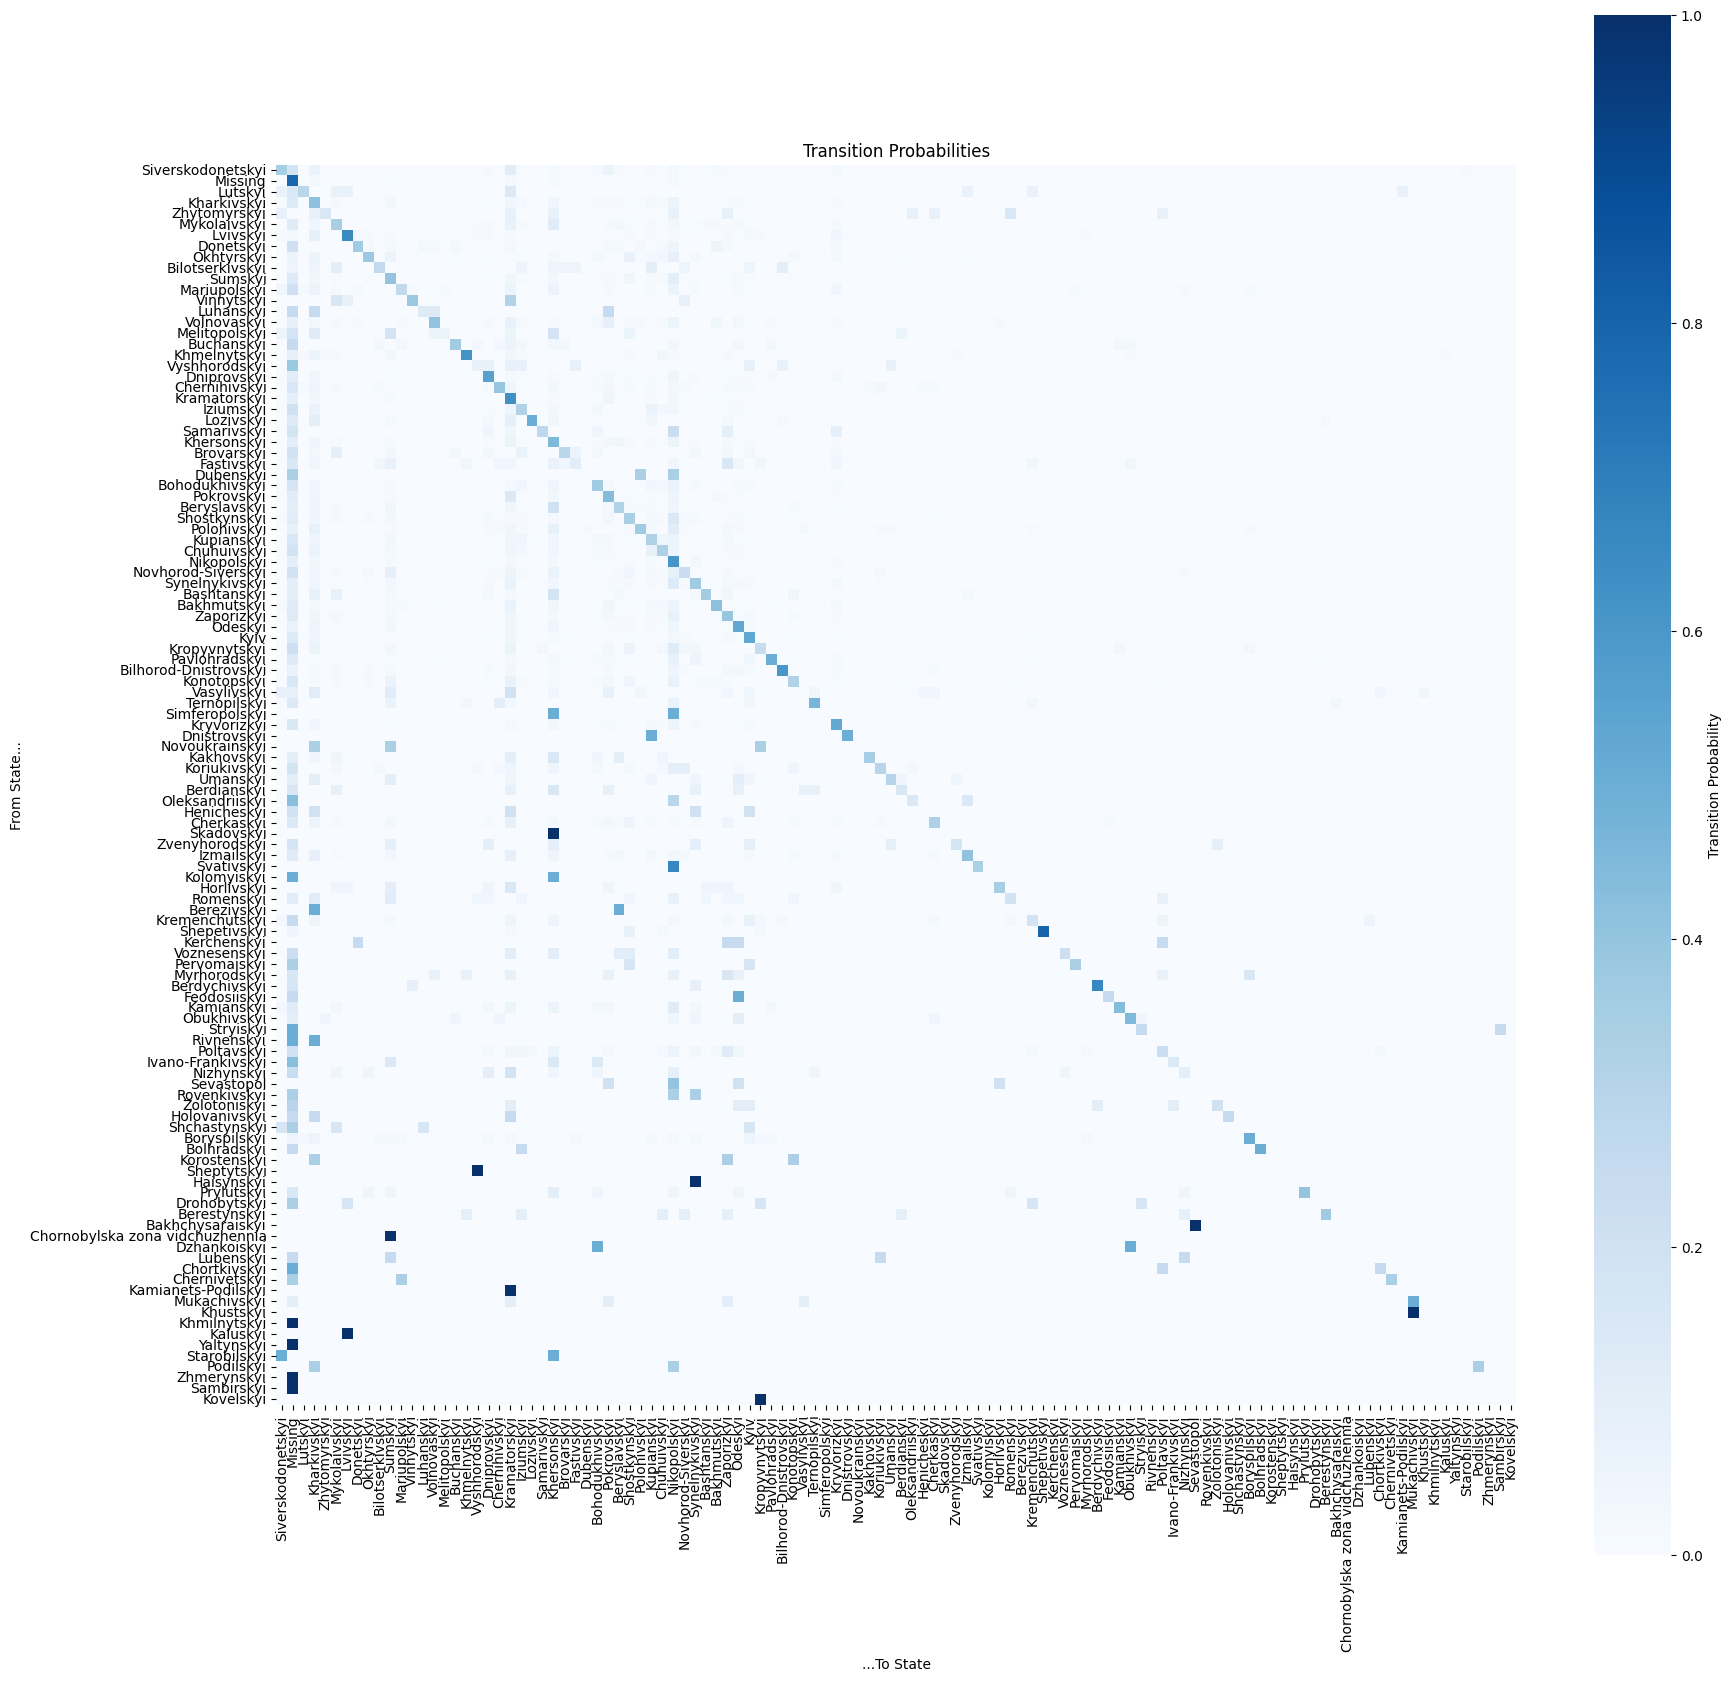

In [14]:
plt.figure(figsize=(20, 20))
sns.heatmap(tr_pr_r, 
            cmap='Blues',    
            square=True,          
            xticklabels=states_r,
            yticklabels=states_r,
            cbar_kws={'label': 'Transition Probability'})

plt.title('Transition Probabilities')
plt.xlabel('...To State')
plt.ylabel('From State...')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### Markov Projections for Rayon Analysis

In [17]:
# rayon projections

# transition matrix: rayon_tr_df
# rayon[0] Siverskodonetskyi

length_r = len(rayon_tr_df.columns)

# find the index of the starting point
for i in range(length_r):
    if rayon_tr_df.columns[i] == "Siverskodonetskyi":
        starting_point_r = i
# initiate the projection matrix and set starting point
init_r = np.zeros(length_r)
init_r[starting_point_r] = 1
#print(init)

time_windows = [5, 10, 25, 50, 100, 250, 500, 750, 1000, 2000]

init5_r = init_r
for i in range(5):
    init5_r =  init5_r@tr_pr_r

#print(init2)

init10_r = init_r
for i in range(10):
   init10_r = init10_r@tr_pr_r

init25_r = init_r
for i in range(25):
   init25_r = init25_r@tr_pr_r

init50_r = init_r
for i in range(50):
   init50_r = init50_r@tr_pr_r

init100_r = init_r
for i in range(100):
   init100_r = init100_r@tr_pr_r

init250_r = init_r
for i in range(250):
   init250_r = init250_r@tr_pr_r

init500_r = init_r
for i in range(500):
   init500_r = init500_r@tr_pr_r

init750_r = init_r
for i in range(750):
   init750_r = init750_r@tr_pr_r

init1000_r = init_r
for i in range(1000):
   init1000_r = init1000_r@tr_pr_r

init2000_r = init_r
for i in range(2000):
   init2000_r = init2000_r@tr_pr_r

projections_r = pd.DataFrame({"initial": init_r,
                            "after 5 strikes": init5_r,
                            "after 10 strikes": init10_r,
                            "after 25 strikes": init25_r,
                            "after 50 strikes": init50_r,
                            "After 100 strikes": init100_r,
                            "After 250 strikes": init250_r,
                            "After 500 strikes": init500_r,
                            "After 750 strikes": init750_r,
                            "After 1000 strikes": init1000_r,
                            "After 2000 strikes": init2000_r})
projections_r

,initial,after 5 strikes,after 10 strikes,after 25 strikes,after 50 strikes,After 100 strikes,After 250 strikes,After 500 strikes,After 750 strikes,After 1000 strikes,After 2000 strikes
0,1.0,0.013363,0.006694,0.006571,0.006571,0.006571,0.006571,0.006571,0.006571,0.006571,0.006571
1,0.0,0.336092,0.356089,0.359299,0.359307,0.359307,0.359307,0.359307,0.359307,0.359307,0.359307
2,0.0,0.000550,0.000578,0.000577,0.000577,0.000577,0.000577,0.000577,0.000577,0.000577,0.000577
3,0.0,0.057097,0.054121,0.053897,0.053896,0.053896,0.053896,0.053896,0.053896,0.053896,0.053896
4,0.0,0.000467,0.000531,0.000536,0.000536,0.000536,0.000536,0.000536,0.000536,0.000536,0.000536
...,...,...,...,...,...,...,...,...,...,...,...
109,0.0,0.000300,0.000085,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082
110,0.0,0.000110,0.000123,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124
111,0.0,0.000037,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041
112,0.0,0.000025,0.000040,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041


### Yikes, rayon is NOT a useful predictor.

# Infrastructure Markov Projections

What type of buildings are targeted? is there order?

In [15]:
#how many type_of_infrastructure rows are NaN?
data['type_of_infrastructure'].isna().sum()

np.int64(4)

In [16]:
#Fill NaN with 'Unknown'
data['type_of_infrastructure'] = data['type_of_infrastructure'].fillna('Unknown')
data['type_of_infrastructure'].value_counts()

type_of_infrastructure
Industrial/Business/Enterprise facilities    5056
Education facility (school, etc.)            5021
Electricity supply system                    3016
Government facilities                        2060
Gas supply system                            1968
                                             ... 
Oil depot                                      51
Airport                                        25
Nuclear unit                                    7
Unknown                                         4
Aircraft repair plant                           3
Name: count, Length: 26, dtype: int64

In [17]:
infrastructure1 = data[['type_of_infrastructure']].copy()
infrastructure1.reset_index(drop=True, inplace=True)
infrastructure1.head(20)

,type_of_infrastructure
0,Warehouse
1,Warehouse
2,Warehouse
3,Aircraft repair plant
4,Bridge
...,...
15,"Education facility (school, etc.)"
16,"Education facility (school, etc.)"
17,Oil depot
18,Gas supply system


In [18]:
states_i1 = list(infrastructure1["type_of_infrastructure"].unique())
states_i1

['Warehouse',
 'Aircraft repair plant',
 'Bridge',
 'Oil depot',
 'Nuclear unit',
 'Health facility (hospital, health clinic)',
 'Government facilities',
 'Fuel depot',
 'Education facility (school, etc.)',
 'Gas supply system',
 'Religious facilities',
 'Telecommunications',
 'Airport',
 'Power plant',
 'Industrial/Business/Enterprise facilities',
 'Electricity supply system',
 'Water supply system',
 'Chemical storage unit',
 'Heating and water facility',
 'Railway',
 'Cultural facilities (museum, theater etc.)',
 'Other',
 'Unknown',
 'Road / Highway',
 'Harbor',
 'Agricultural facilities']

### Create Transition Matrix for Infrastructure Analysis

In [19]:
# TRANSITION MATRIX - INFRA 1

states_i1 = list(infrastructure1["type_of_infrastructure"].unique())
#states_i2

# step 2: compute transition counts/matrix >> adapting code from bach.py
# REMEMBER, it's a normalized matrix

S_i1 = len(states_i1)
#T = len(bach)
tr_counts_i1 = np.zeros( (S_i1, S_i1) )



## Compute transition counts:
for row in range(1,len(infrastructure1["type_of_infrastructure"])): # check two lines down for why we start at 1

    # Current and next tokens:
    x_tm1 = infrastructure1["type_of_infrastructure"][row-1] # previous state >> this is why we start at 1! bc we are collecting previous state.
    x_t = infrastructure1["type_of_infrastructure"][row] # current state
    # Determine transition indices:
    index_from = states_i1.index(x_tm1)
    index_to = states_i1.index(x_t)
    # Update transition counts:
    tr_counts_i1[index_from, index_to] += 1

#print('Transition Counts:\n', tr_counts_i1)

# Sum the transition counts by row >> numpy axis 0 is technically rows, but visually it's columns. "rows" is what we want
sums_i1 = tr_counts_i1.sum(axis=1, keepdims=True)
#print('State proportions: \n')

# Normalize the transition count matrix to get proportions:
tr_pr_i1 = np.divide(tr_counts_i1, sums_i1, 
                             out=np.zeros_like(tr_counts_i1), 
                             where=sums_i1!=0)

#print('Transition Proportions:\n')

infra1_tr_df = pd.DataFrame(np.round(tr_pr_i1,2), index=states_i1, columns=states_i1)
#infra1_tr_df

# output truncated for brevity

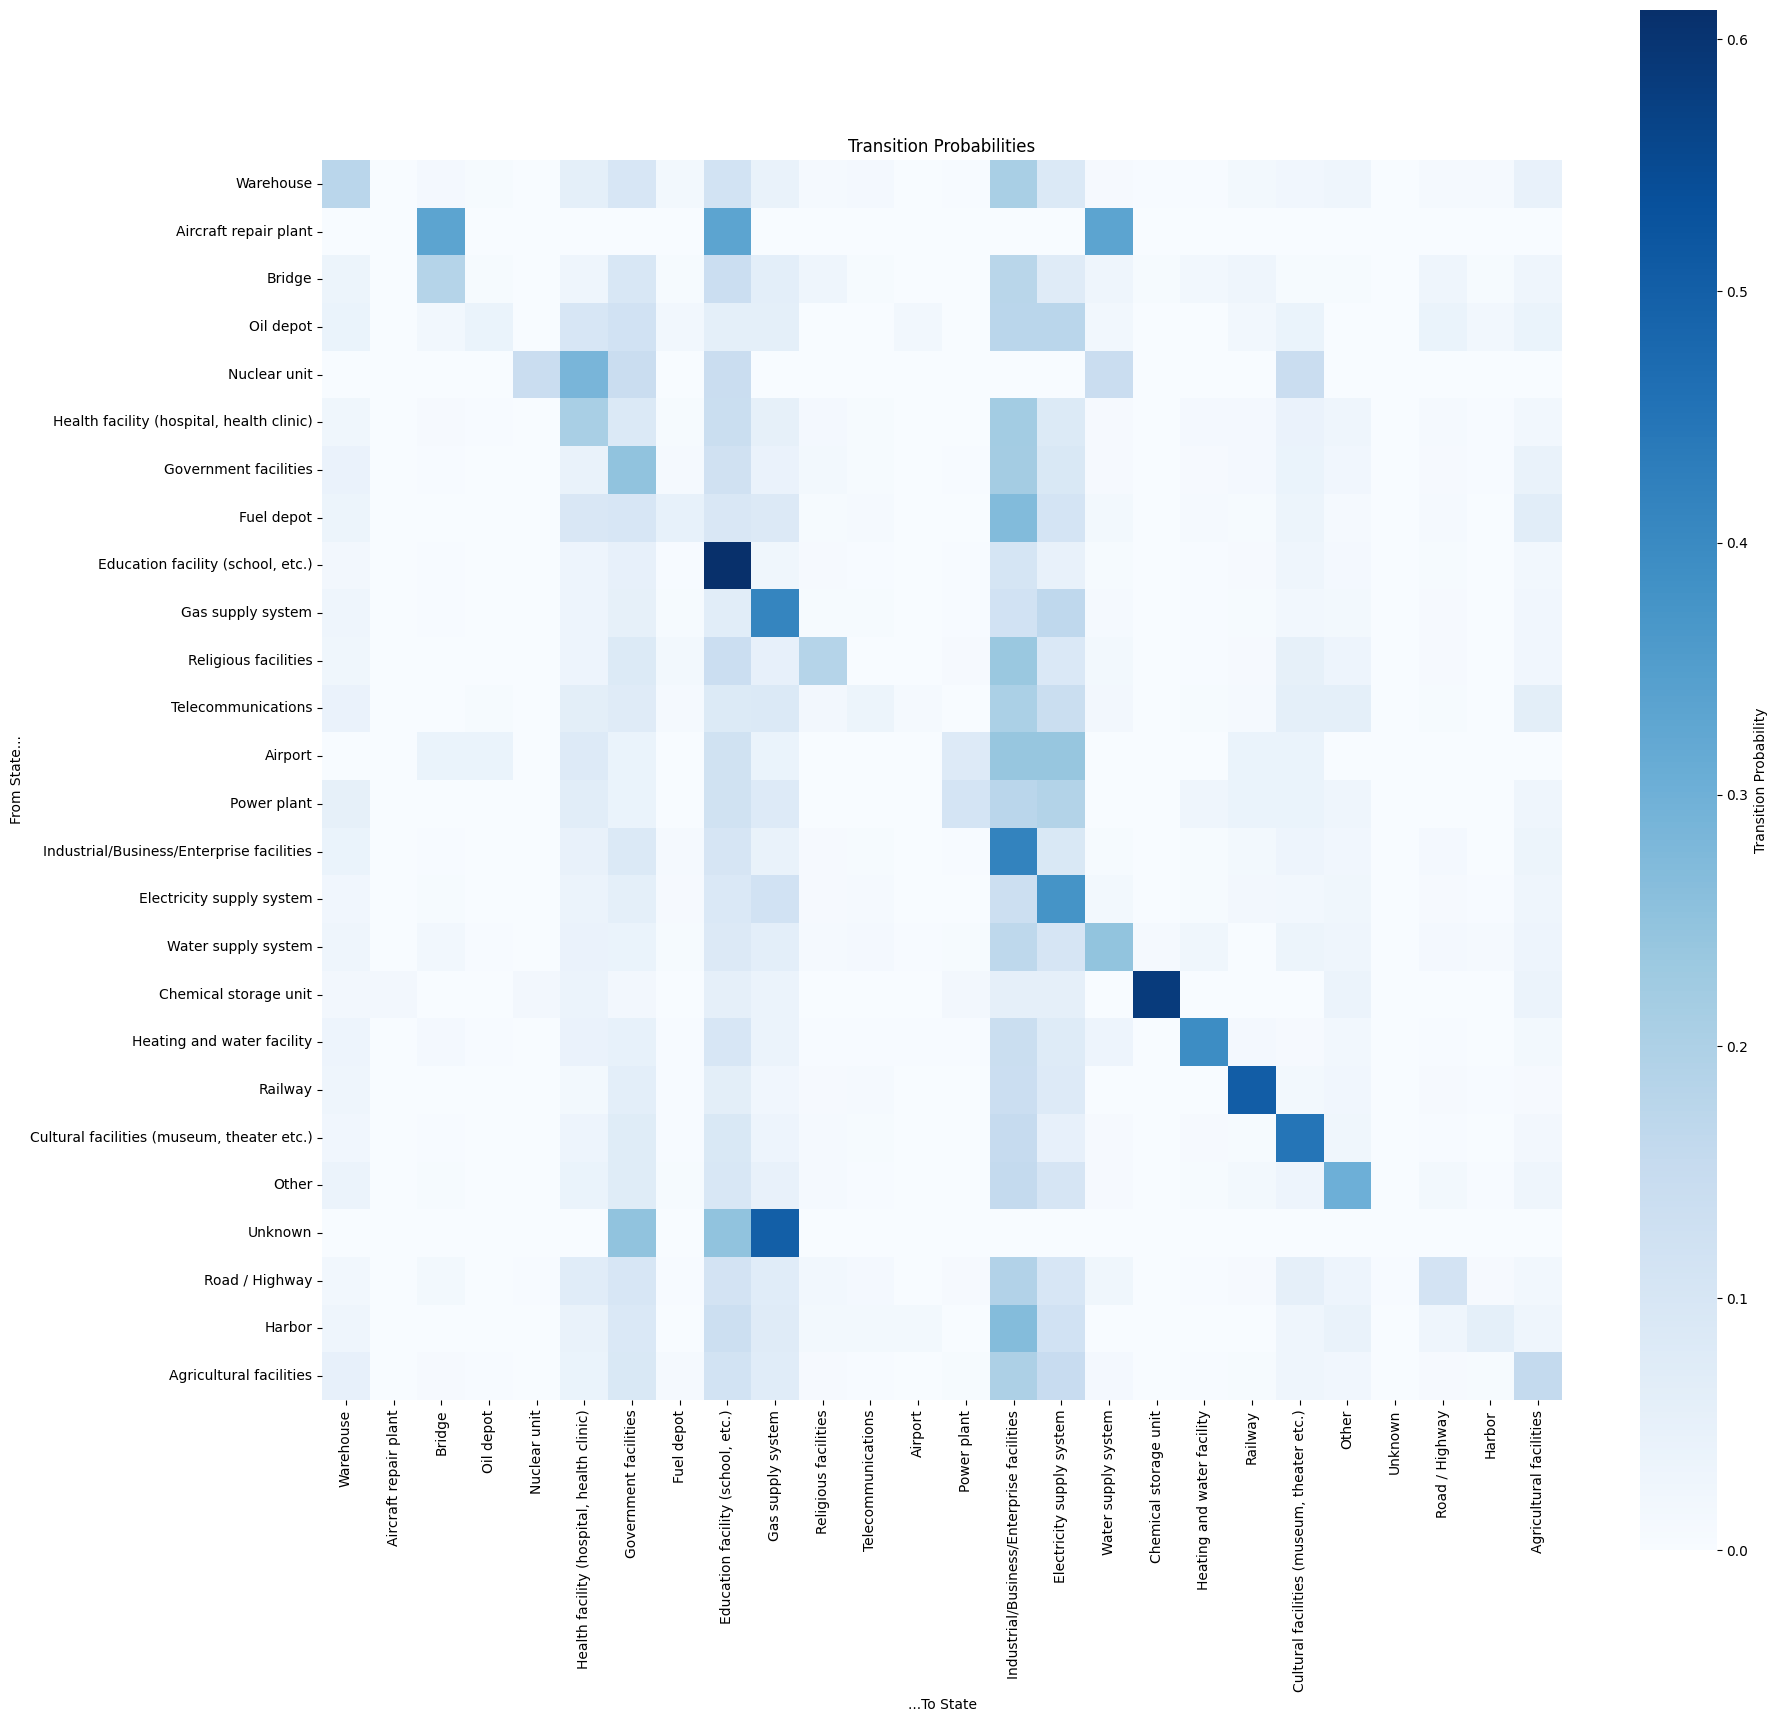

In [20]:
plt.figure(figsize=(20, 20))
sns.heatmap(tr_pr_i1, 
            cmap='Blues',    
            square=True,          
            xticklabels=states_i1,
            yticklabels=states_i1,
            cbar_kws={'label': 'Transition Probability'})

plt.title('Transition Probabilities')
plt.xlabel('...To State')
plt.ylabel('From State...')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### Markov Projections for Infrastructure Analysis

In [24]:
# infrastructure projections

# transition matrix: infra1_tr_df
# infra1: Warehouse

length_i1 = len(infra1_tr_df.columns)

# find the index of the starting point
for i in range(length_i1):
    if infra1_tr_df.columns[i] == "Warehouse":
        starting_point_i1 = i
# initiate the projection matrix and set starting point
init_i1 = np.zeros(length_i1)
init_i1[starting_point_i1] = 1
#print(init)

time_windows = [5, 10, 25, 50, 100, 250, 500, 750, 1000, 2000]

init5_i1 = init_i1
for i in range(5):
    init5_i1 = init5_i1 @ tr_pr_i1
#print(init2)

init10_i1 = init_i1
for i in range(10):
   init10_i1 = init10_i1 @ tr_pr_i1

init25_i1 = init_i1
for i in range(25):
   init25_i1 = init25_i1 @ tr_pr_i1

init50_i1 = init_i1
for i in range(50):
   init50_i1 = init50_i1 @ tr_pr_i1

init100_i1 = init_i1
for i in range(100):
   init100_i1 = init100_i1 @ tr_pr_i1

init250_i1 = init_i1
for i in range(250):
   init250_i1 = init250_i1 @ tr_pr_i1

init500_i1 = init_i1
for i in range(500):
   init500_i1 = init500_i1 @ tr_pr_i1

init750_i1 = init_i1
for i in range(750):
   init750_i1 = init750_i1 @ tr_pr_i1

init1000_i1 = init_i1
for i in range(1000):
   init1000_i1 = init1000_i1 @ tr_pr_i1

init2000_i1 = init_i1
for i in range(2000):
   init2000_i1 = init2000_i1 @ tr_pr_i1

projections_i1 = pd.DataFrame({"initial": init_i1,
                            "after 5 strikes": init5_i1,
                            "after 10 strikes": init10_i1,
                            "after 25 strikes": init25_i1,
                            "after 50 strikes": init50_i1,
                            "After 100 strikes": init100_i1,
                            "After 250 strikes": init250_i1,
                            "After 500 strikes": init500_i1,
                            "After 750 strikes": init750_i1,
                            "After 1000 strikes": init1000_i1,
                            "After 2000 strikes": init2000_i1})
projections_i1

,initial,after 5 strikes,after 10 strikes,after 25 strikes,after 50 strikes,After 100 strikes,After 250 strikes,After 500 strikes,After 750 strikes,After 1000 strikes,After 2000 strikes
0,1.0,0.034670,0.034324,0.034318,0.034318,0.034318,0.034318,0.034318,0.034318,0.034318,0.034318
1,0.0,0.000135,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124
2,0.0,0.006090,0.006017,0.006016,0.006016,0.006016,0.006016,0.006016,0.006016,0.006016,0.006016
3,0.0,0.002115,0.002102,0.002101,0.002101,0.002101,0.002101,0.002101,0.002101,0.002101,0.002101
4,0.0,0.000298,0.000289,0.000288,0.000288,0.000288,0.000288,0.000288,0.000288,0.000288,0.000288
...,...,...,...,...,...,...,...,...,...,...,...
21,0.0,0.030105,0.029841,0.029833,0.029833,0.029833,0.029833,0.029833,0.029833,0.029833,0.029833
22,0.0,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165
23,0.0,0.010190,0.010097,0.010096,0.010096,0.010096,0.010096,0.010096,0.010096,0.010096,0.010096
24,0.0,0.002791,0.002761,0.002760,0.002760,0.002760,0.002760,0.002760,0.002760,0.002760,0.002760


### It's not very helpful.  There are too many categories for there to be any standouts...

# Infrastructure Markov Chain 2

What if we collapse the 'type_of_infrastructure' attribute into fewer categories?  Could we come to a more informative (practical) inference?

In [21]:
"""
CATEGORICAL RECODING FOR INFRASTRUCTURE

Business
  Industrial/Business/Enterprise facilities
  Warehouse

Civillian
  Education facility (school, etc.)
  Cultural facilities (museum, theater etc.)
  Health facility (hospital, health clinic)
  Religious facilities
  Telecommunications

Power & Fuel
  Oil depot
  Chemical storage unit 
  Fuel depot
  Gas supply system
  Electricity supply system
  Nuclear unit
  Power plant 

Resources
  Agricultural facilities
  Water supply system
  Heating and water facility 
  Chemical storage unit 

Transportation
  Aircraft repair plant
  Airport
  Harbor
  Bridge
  Railway
  Road / Highway

Other

Government facilities 

Unknown

"""

infra_mapping = {
    # old_name: new_name
    "Industrial/Business/Enterprise facilities":    "Business",
    "Warehouse":                                    "Business",

    "Education facility (school, etc.)":            "Civillian",
    "Cultural facilities (museum, theater etc.)":   "Civillian",
    "Health facility (hospital, health clinic)":    "Civillian",
    "Religious facilities":                         "Civillian",
    "Telecommunications":                           "Civillian",

    "Oil depot":                    "Power & Fuel",
    "Chemical storage unit":        "Power & Fuel",
    "Fuel depot":                   "Power & Fuel",
    "Gas supply system":            "Power & Fuel",
    "Electricity supply system":    "Power & Fuel",
    "Nuclear unit":                 "Power & Fuel",
    "Power plant":                  "Power & Fuel",

    "Agricultural facilities":      "Resources",
    "Water supply system":          "Resources",
    "Heating and water facility":   "Resources",
    "Chemical storage unit":        "Resources",

    "Aircraft repair plant":    "Transportation",
    "Airport":                  "Transportation",
    "Harbor":                   "Transportation",
    "Bridge":                   "Transportation",
    "Railway":                  "Transportation",
    "Road / Highway":           "Transportation",

    "Other": "Other",

    "Unknown":  "Unknown",

    "Government facilities": "Government facilities"
}

# create a copy of dataframe, isolate the column
# then use .map()

data['type_of_infrastructure'] = data['type_of_infrastructure'].fillna('Unknown')
infrastructure = data[['type_of_infrastructure']].copy()
infrastructure.reset_index(drop=True, inplace=True)
infrastructure['type_of_infrastructure'] = infrastructure['type_of_infrastructure'].map(infra_mapping)

infrastructure["type_of_infrastructure"].value_counts()

type_of_infrastructure
Civillian                7848
Business                 5890
Power & Fuel             5319
Government facilities    2060
Resources                1382
Transportation           1042
Other                     724
Unknown                     4
Name: count, dtype: int64

### Updated Infrastructure Transition Matrix

In [22]:
# RE-DO THE INFRASTRUCTURE TRANSITION MATRIX

states_i2 = list(infrastructure["type_of_infrastructure"].unique())
#states_i2

# step 2: compute transition counts/matrix >> adapting code from bach.py
# REMEMBER, it's a normalized matrix

S_i2 = len(states_i2)
#T = len(bach)
tr_counts_i2 = np.zeros( (S_i2, S_i2) )



## Compute transition counts:
for row in range(1,len(infrastructure["type_of_infrastructure"])): # check two lines down for why we start at 1

    # Current and next tokens:
    x_tm1 = infrastructure["type_of_infrastructure"][row-1] # previous state >> this is why we start at 1! bc we are collecting previous state.
    x_t = infrastructure["type_of_infrastructure"][row] # current state
    # Determine transition indices:
    index_from = states_i2.index(x_tm1)
    index_to = states_i2.index(x_t)
    # Update transition counts:
    tr_counts_i2[index_from, index_to] += 1

#print('Transition Counts:\n', tr_counts_i2)

# Sum the transition counts by row >> numpy axis 0 is technically rows, but visually it's columns. "rows" is what we want
sums_i2 = tr_counts_i2.sum(axis=1, keepdims=True)
#print('State proportions: \n')

# Normalize the transition count matrix to get proportions:
tr_pr_i2 = np.divide(tr_counts_i2, sums_i2, 
                             out=np.zeros_like(tr_counts_i2), 
                             where=sums_i2!=0)

#print('Transition Proportions:\n')

infra2_tr_df = pd.DataFrame(np.round(tr_pr_i2,2), index=states_i2, columns=states_i2)
#infra2_tr_df

# output truncated for brevity

### Updated Infrastructure Markov Projections

In [23]:
# infrastructure recoded projections

# transition matrix: infra2_tr_df
# infra1: Warehouse >> infra2: __________

length_i2 = len(infra2_tr_df.columns)

# find the index of the starting point
for i in range(length_i2):
    if infra2_tr_df.columns[i] == "Business": 
        starting_point_i2 = i
# initiate the projection matrix and set starting point
init_i2 = np.zeros(length_i2)
init_i2[starting_point_i2] = 1
#print(init)

time_windows = [5, 10, 25, 50, 100, 250, 500, 750, 1000, 2000]

init5_i2 = init_i2
for i in range(5):
    init5_i2 = init5_i2 @ tr_pr_i2
#print(init2)

init10_i2 = init_i2
for i in range(10):
   init10_i2 = init10_i2 @ tr_pr_i2

init15_i2 = init_i2
for i in range(15):
   init15_i2 = init15_i2 @ tr_pr_i2

init20_i2 = init_i2
for i in range(20):
   init20_i2 = init20_i2 @ tr_pr_i2  

init25_i2 = init_i2
for i in range(25):
   init25_i2 = init25_i2 @ tr_pr_i2

init50_i2 = init_i2
for i in range(50):
   init50_i2 = init50_i2 @ tr_pr_i2

init100_i2 = init_i2
for i in range(100):
   init100_i2 = init100_i2 @ tr_pr_i2

init250_i2 = init_i2
for i in range(250):
   init250_i2 = init250_i2 @ tr_pr_i2

init500_i2 = init_i2
for i in range(500):
   init500_i2 = init500_i2 @ tr_pr_i2
"""
init750_i2 = init_i2
for i in range(750):
   init750_i2 = init750_i2 @ tr_pr_i2

init1000_i2 = init_i2
for i in range(1000):
   init1000_i2 = init1000_i2 @ tr_pr_i2
"""
   
init2000_i2 = init_i2
for i in range(2000):
   init2000_i2 = init2000_i2 @ tr_pr_i2

projections_i2 = pd.DataFrame({"initial": init_i2,
                            "after 5 strikes": init5_i2,
                            "after 10 strikes": init10_i2,
                            "after 15 strikes": init15_i2,
                            "after 20 strikes": init20_i2,
                            "after 25 strikes": init25_i2,
                            "after 50 strikes": init50_i2,
                            "After 100 strikes": init100_i2,
                            "After 250 strikes": init250_i2,
                            "After 500 strikes": init500_i2,
                            "After 2000 strikes": init2000_i2})
projections_i2

,initial,after 5 strikes,after 10 strikes,after 15 strikes,after 20 strikes,after 25 strikes,after 50 strikes,After 100 strikes,After 250 strikes,After 500 strikes,After 2000 strikes
0,1.0,0.244347,0.242673,0.242665,0.242665,0.242665,0.242665,0.242665,0.242665,0.242665,0.242665
1,0.0,0.043264,0.042942,0.042937,0.042937,0.042937,0.042937,0.042937,0.042937,0.042937,0.042937
2,0.0,0.219440,0.219200,0.219178,0.219178,0.219178,0.219178,0.219178,0.219178,0.219178,0.219178
3,0.0,0.320494,0.323350,0.323388,0.323389,0.323389,0.323389,0.323389,0.323389,0.323389,0.323389
4,0.0,0.085229,0.084887,0.084885,0.084885,0.084885,0.084885,0.084885,0.084885,0.084885,0.084885
5,0.0,0.057161,0.056950,0.056947,0.056947,0.056947,0.056947,0.056947,0.056947,0.056947,0.056947
6,0.0,0.029902,0.029834,0.029834,0.029834,0.029834,0.029834,0.029834,0.029834,0.029834,0.029834
7,0.0,0.000163,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165


## MUCH better.  Now we can see targets grouped under "civilian infrastructure" are by far most likely to be targeted in the future according to the data.